In [1]:
import torch
from CSPDarknet_depthwise import *
import requests
import zipfile
from pathlib import Path
import numpy

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
device = "cuda:4"

def download_dataset():
    data_path = Path("data/")
    image_path = data_path / "pizza_steak_sushi"
    
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
    else:
        print(f"Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
            request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
            print("Downloading pizza, steak, sushi data...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)

In [3]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str or pathlib.Path): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc



def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    """torch.save(model, "csp.pt")
    torch.onnx.export(model.to("cpu"), torch.randn(1, 3, 640, 640).to("cpu"), "batch_csp_640.onnx", export_params=True, do_constant_folding=True)
    model.to(device)"""
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [5]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

download_dataset()
walk_through_dir(image_path)


# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(640, 640)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.RandomRotation(degrees=0.2),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])
# Use ImageFolder to create dataset(s)

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

CSP = CSPDarknet(3, 16).to(device)

img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0).to(device), label_batch[0]

CSP.eval()
with torch.inference_mode():
    pred = CSP(img_single)
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

NUM_EPOCHS = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CSP.parameters(), lr=0.001)

res = train(model=CSP, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
           optimizer=optimizer,
           loss_fn=loss_fn,
           epochs=NUM_EPOCHS)

data/pizza_steak_sushi directory exists.
There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(640, 640), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFl

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.7993 | train_acc: 0.3600 | test_loss: 8.1135 | test_acc: 0.3467
Epoch: 2 | train_loss: 2.5317 | train_acc: 0.4133 | test_loss: 2.7462 | test_acc: 0.3467
Epoch: 3 | train_loss: 1.6114 | train_acc: 0.5067 | test_loss: 2.8611 | test_acc: 0.4000
Epoch: 4 | train_loss: 1.7278 | train_acc: 0.4978 | test_loss: 1.3730 | test_acc: 0.3733
Epoch: 5 | train_loss: 2.1255 | train_acc: 0.3822 | test_loss: 2.2188 | test_acc: 0.3067
Epoch: 6 | train_loss: 2.2132 | train_acc: 0.4178 | test_loss: 3.3123 | test_acc: 0.3867
Epoch: 7 | train_loss: 2.1724 | train_acc: 0.4444 | test_loss: 4.4033 | test_acc: 0.3200
Epoch: 8 | train_loss: 2.4669 | train_acc: 0.4267 | test_loss: 6.3460 | test_acc: 0.2667
Epoch: 9 | train_loss: 1.8019 | train_acc: 0.5689 | test_loss: 3.3131 | test_acc: 0.3867
Epoch: 10 | train_loss: 1.2709 | train_acc: 0.6889 | test_loss: 5.6703 | test_acc: 0.3600
Epoch: 11 | train_loss: 1.8670 | train_acc: 0.4667 | test_loss: 2.3790 | test_acc: 0.4800
Epoch: 12 | train_l

In [6]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

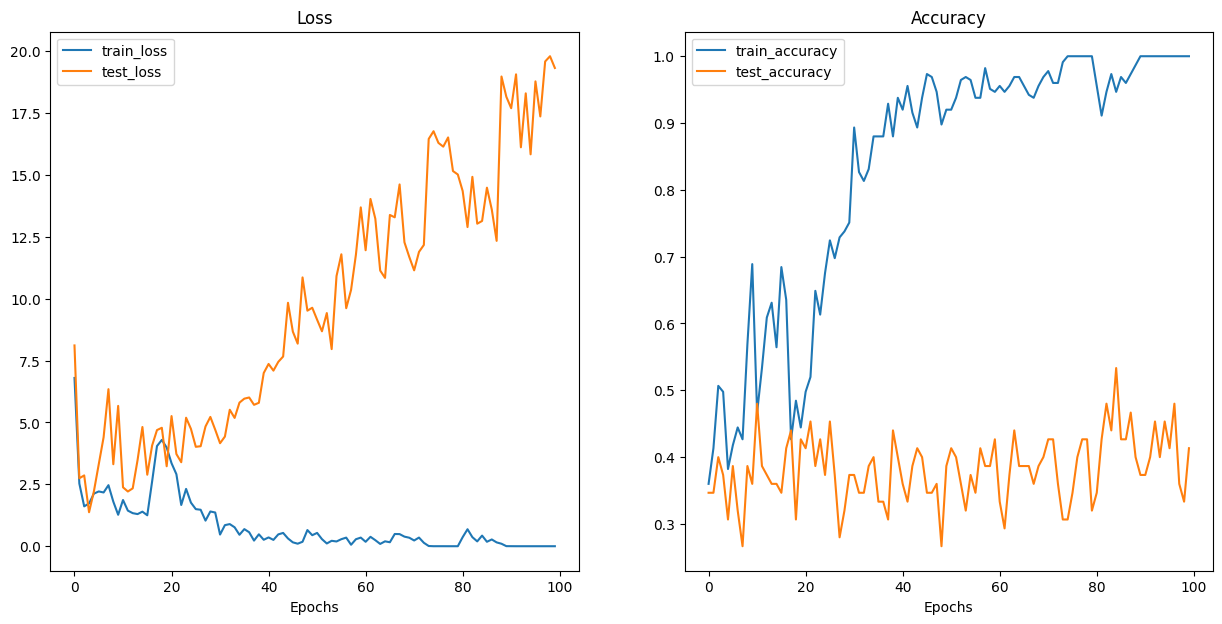

In [7]:
plot_loss_curves(res)

In [8]:
CSP.to("cuda:4").eval()

CSPDarknet(
  (focus): Focus_pointsize(
    (conv1): Sequential(
      (0): Conv2d(3, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), groups=3)
      (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), groups=3)
        (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05

In [9]:
torch.onnx.export(CSP, torch.randn(1, 3, 640, 640).to("cuda:4"), "CspDarknet_Focus_depthwise.onnx", input_names=['input'], output_names=['output'])

In [10]:
CSP.to("cpu")

CSPDarknet(
  (focus): Focus_pointsize(
    (conv1): Sequential(
      (0): Conv2d(3, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), groups=3)
      (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), groups=3)
        (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05

In [13]:
import onnx
import tensorrt as trt

In [14]:
name_model_trt = "CspDarknet_focus_depthwise.engine"

logger = trt.Logger(trt.Logger.INFO)
builder = trt.Builder(logger)

config = builder.create_builder_config()
config.max_workspace_size = 1 << 30

flag = (1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
network = builder.create_network(flag)
parser = trt.OnnxParser(network, logger)
if not parser.parse_from_file("CspDarknet_Focus_depthwise.onnx"):
    print("Failed to load ONNX file")
    
inputs = [network.get_input(i) for i in range(network.num_inputs)]
outputs = [network.get_output(i) for i in range(network.num_outputs)]
for inp in inputs:
    print(f'input "{inp.name}" with shape{inp.shape} {inp.dtype}')
for out in outputs:
    print(f'output "{out.name}" with shape{out.shape} {out.dtype}')
half = False
if builder.platform_has_fast_fp16 and half:
    config.set_flag(trt.BuilderFlag.FP16)
with builder.build_engine(network, config) as engine, open(name_model_trt, 'wb') as t:
    t.write(engine.serialize())

/tmp/ipykernel_4120850/604433170.py:7: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 1 << 30
/tmp/ipykernel_4120850/604433170.py:24: DeprecationWarning: Use build_serialized_network instead.
  with builder.build_engine(network, config) as engine, open(name_model_trt, 'wb') as t:


[04/28/2023-16:25:58] [TRT] [I] [MemUsageChange] Init CUDA: CPU +9, GPU +0, now: CPU 1458, GPU 775 (MiB)
[04/28/2023-16:26:02] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +171, GPU +46, now: CPU 1684, GPU 821 (MiB)
[04/28/2023-16:26:02] [TRT] [I] ----------------------------------------------------------------
[04/28/2023-16:26:02] [TRT] [I] Input filename:   CspDarknet_Focus_depthwise.onnx
[04/28/2023-16:26:02] [TRT] [I] ONNX IR version:  0.0.7
[04/28/2023-16:26:02] [TRT] [I] Opset version:    14
[04/28/2023-16:26:02] [TRT] [I] Producer name:    pytorch
[04/28/2023-16:26:02] [TRT] [I] Producer version: 1.13.1
[04/28/2023-16:26:02] [TRT] [I] Domain:           
[04/28/2023-16:26:02] [TRT] [I] Model version:    0
[04/28/2023-16:26:02] [TRT] [I] Doc string:       
[04/28/2023-16:26:02] [TRT] [I] ----------------------------------------------------------------
input "input" with shape(1, 3, 640, 640) DataType.FLOAT
output "output" with shape(1, 3) DataType.FLOAT
[04/28/2023

In [15]:
name_model_trt = "CspDarknet_focus.engine"

logger = trt.Logger(trt.Logger.INFO)
builder = trt.Builder(logger)

config = builder.create_builder_config()
config.max_workspace_size = 1 << 30

flag = (1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
network = builder.create_network(flag)
parser = trt.OnnxParser(network, logger)
if not parser.parse_from_file("CspDarknet_Focus.onnx"):
    print("Failed to load ONNX file")
    
inputs = [network.get_input(i) for i in range(network.num_inputs)]
outputs = [network.get_output(i) for i in range(network.num_outputs)]
for inp in inputs:
    print(f'input "{inp.name}" with shape{inp.shape} {inp.dtype}')
for out in outputs:
    print(f'output "{out.name}" with shape{out.shape} {out.dtype}')
half = False
if builder.platform_has_fast_fp16 and half:
    config.set_flag(trt.BuilderFlag.FP16)
with builder.build_engine(network, config) as engine, open(name_model_trt, 'wb') as t:
    t.write(engine.serialize())

/tmp/ipykernel_4120850/2188519521.py:7: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 1 << 30
/tmp/ipykernel_4120850/2188519521.py:24: DeprecationWarning: Use build_serialized_network instead.
  with builder.build_engine(network, config) as engine, open(name_model_trt, 'wb') as t:


[04/28/2023-16:38:13] [TRT] [I] The logger passed into createInferBuilder differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[04/28/2023-16:38:13] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 1910, GPU 845 (MiB)
[04/28/2023-16:38:13] [TRT] [I] ----------------------------------------------------------------
[04/28/2023-16:38:13] [TRT] [I] Input filename:   CspDarknet_Focus.onnx
[04/28/2023-16:38:13] [TRT] [I] ONNX IR version:  0.0.7
[04/28/2023-16:38:13] [TRT] [I] Opset version:    14
[04/28/2023-16:38:13] [TRT] [I] Producer name:    pytorch
[04/28/2023-16:38:13] [TRT] [I] Producer version: 1.13.1
[04/28/2023-16:38:13] [TRT] [I] Domain:           
[04/28/2023-16:38:13] [TRT] [I] Model version:    0
[04/28/2023-16:38:13] [TRT] [I] Doc string:       
[04/28/2023-16:38:13] [TRT] [I] ----------------------------------------------------------------
i